# Creating a Sentiment Predictor

I want to create a sentiment predictor that can predict the sentiment of a sentence by the word choice of the writer.

To develop this model, I will use review data from Amazon, specifically from their music department.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import codecs
import random
from collections import Counter
from IPython.core.display import HTML
from sklearn.naive_bayes import BernoulliNB
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn import ensemble
from sklearn.model_selection import cross_val_score
from sklearn.metrics import confusion_matrix
from sklearn.utils import resample

%matplotlib inline

## Importing the Data

In [2]:
import json 

with open('C:\\Code\\Data\\music.json') as f: 
    music = pd.DataFrame(json.loads(line) for line in f)

In [3]:
print(music.shape)
display(music.head())

(10261, 9)


,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,1384719342,"[0, 0]",5.0,"Not much to write about here, but it does exac...","02 28, 2014",A2IBPI20UZIR0U,"cassandra tu ""Yeah, well, that's just like, u...",good,1393545600
1,1384719342,"[13, 14]",5.0,The product does exactly as it should and is q...,"03 16, 2013",A14VAT5EAX3D9S,Jake,Jake,1363392000
2,1384719342,"[1, 1]",5.0,The primary job of this device is to block the...,"08 28, 2013",A195EZSQDW3E21,"Rick Bennette ""Rick Bennette""",It Does The Job Well,1377648000
3,1384719342,"[0, 0]",5.0,Nice windscreen protects my MXL mic and preven...,"02 14, 2014",A2C00NNG1ZQQG2,"RustyBill ""Sunday Rocker""",GOOD WINDSCREEN FOR THE MONEY,1392336000
4,1384719342,"[0, 0]",5.0,This pop filter is great. It looks and perform...,"02 21, 2014",A94QU4C90B1AX,SEAN MASLANKA,No more pops when I record my vocals.,1392940800


In [4]:
music.reviewText[music.overall>=4]

0        Not much to write about here, but it does exac...
1        The product does exactly as it should and is q...
2        The primary job of this device is to block the...
3        Nice windscreen protects my MXL mic and preven...
4        This pop filter is great. It looks and perform...
5        So good that I bought another one.  Love the h...
6        I have used monster cables for years, and with...
8        Perfect for my Epiphone Sheraton II.  Monster ...
9        Monster makes the best cables and a lifetime w...
10       Monster makes a wide array of cables, includin...
11       I got it to have it if I needed it. I have fou...
13       I love it, I used this for my Yamaha ypt-230 a...
14       I bought this to use in my home studio to cont...
16       This Fender cable is the perfect length for me...
17       wanted it just on looks alone...It is a nice l...
18       I've been using these cables for more than 4 m...
19       Fender cords look great and work just as well..

In [5]:
music.reviewText[music.overall<=2]

15       I bought this to use with my keyboard. I wasn'...
50       I didn't expect this cable to be so thin. It's...
52       It hums, crackles, and I think I'm having prob...
89       I'm a pro-cheapo and I hated this thing. They'...
98       I bought this for my Canon Vixia HF G10 Video ...
144      I got 3 of these to plug XLR cables into the 1...
223      Received it in time, standard blister packagin...
224      These things are terrible. One wouldn't fit in...
286      The handle and spring strength make this uncom...
335      it's good but think its a bit expensive for ju...
376      The Epiphone Les Paul guitars don't particular...
408      This is a cheap piece of junk that does what i...
412      From Greg Abrams review, entitled "For all but...
413      Here's the deal with this pedal. It is inexpen...
482      If you want your guitar to sound like Eddie Va...
542      These came stock on my Jackson Kelly KEXMG. Al...
544      I was very disappointed in both the quality an.

There are more than 10,000 reviews. While the dataframe has 9 columns, the only 2 I am interested in are the review text column, where I will be getting all my features, and the review score column, where I will be getting my outcome.

# Creating Features

Now I will parse through the review text and make features which indicate whether or not certain words are in the review. I will focus on looking for words which will usually indicate a positive review score and those which usually indicate a negative review score.

In [6]:
features = pd.DataFrame()

features['Score'] = music.overall

#Words that identify a positive
keywords_pos = ['good','great','awesome','like','love','well','best','better','sturdy','solid',
                'excellent','must have','exactly','wonderful','nice','budget']

for key in keywords_pos:
    features[str(key)] = music.reviewText.str.contains(str(key),case=False)
    
#Words that identify or negative, or rule out a positive
keywords_neg = ["disappoint","hate","awful",'does not work', "doesn't work","negative",'bummed',
                'problem','junk','not enough','waste','regret','terrible','crap','cheap']

for key in keywords_neg:
    features[str(key)] = music.reviewText.str.contains(str(key),case=False)
    
#Create a feature for whether or not the review was overall positive
features['Positive'] = np.where(features['Score']>=4, 1, 0)

# Take out reviews which were rated 3, as whether or not they were positive could be ambiguous`
features_c = features[features.Score != 3.0]

In [7]:
print(features.shape)
display(features.head())

(10261, 33)


,Score,good,great,awesome,like,love,well,best,better,sturdy,...,bummed,problem,junk,not enough,waste,regret,terrible,crap,cheap,Positive
0,5.0,False,False,False,False,False,True,False,False,False,...,False,False,False,False,False,False,False,False,False,1
1,5.0,False,False,False,True,False,True,False,True,False,...,False,False,False,False,False,False,False,False,False,1
2,5.0,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,1
3,5.0,False,False,False,False,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,1
4,5.0,False,True,False,True,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,1


In [8]:
print(features['Positive'].value_counts())

1    9022
0    1239
Name: Positive, dtype: int64


Though the classes are now binary, the outcome is extremely imbalanced. I must resample to get better results from my models.

# Resampling

I will resample both classes until I have 1000 data points from each, for a total of 2000 training data points.

In [9]:
pos = features[features.Positive==1]
neg = features[features.Positive==0]
 
# Downsample positive review class
pos_downsampled = resample(pos, replace=False, n_samples=1000)
#Upsample negative review class
neg_upsampled = resample(neg, replace=False, n_samples=1000)

features_s = pd.concat([pos_downsampled, neg_upsampled])
 
# Display new class counts
display(features_s.Positive.value_counts())

1    1000
0    1000
Name: Positive, dtype: int64

# Modeling

In [10]:
Xs = features_s.drop(['Score','Positive'], axis=1)
Ys = features_s.Positive

Xt = features.drop(['Score','Positive'], axis=1)
Yt = features.Positive

In [11]:
# create data frame to hold test accuracy scores in
scores = pd.DataFrame()

### Random Forest

I will first model with the random forest. Because it is an ensemble model, it can also tell the importance of features to help improve the model

In [12]:
rfc = ensemble.RandomForestClassifier()

rfc.fit(Xs,Ys)

Y_pred = rfc.predict(Xt)

In [13]:
print('Random Forest')
print('\nTraining Accuracy Score:')
print(rfc.score(Xs,Ys))
cvscores = cross_val_score(rfc, Xs, Ys)
print('\nCross Validation Score:')
print('{}% +/- {}%'.format(round(cvscores.mean(),2),round(cvscores.std()*2,2)))
print('\nTest Accuracy Score')
print(rfc.score(Xt,Yt))
cvscoret = cross_val_score(rfc, Xt, Yt)
print('\nCross Validation Score:')
print('{}% +/- {}%'.format(round(cvscoret.mean(),2),round(cvscoret.std()*2,2)))
print('\nConfusion Matrix:')
print(confusion_matrix(Yt, Y_pred))

Random Forest

Training Accuracy Score:
0.7325

Cross Validation Score:
0.6% +/- 0.0%

Test Accuracy Score
0.5900009745638827

Cross Validation Score:
0.87% +/- 0.0%

Confusion Matrix:
[[ 981  258]
 [3949 5073]]


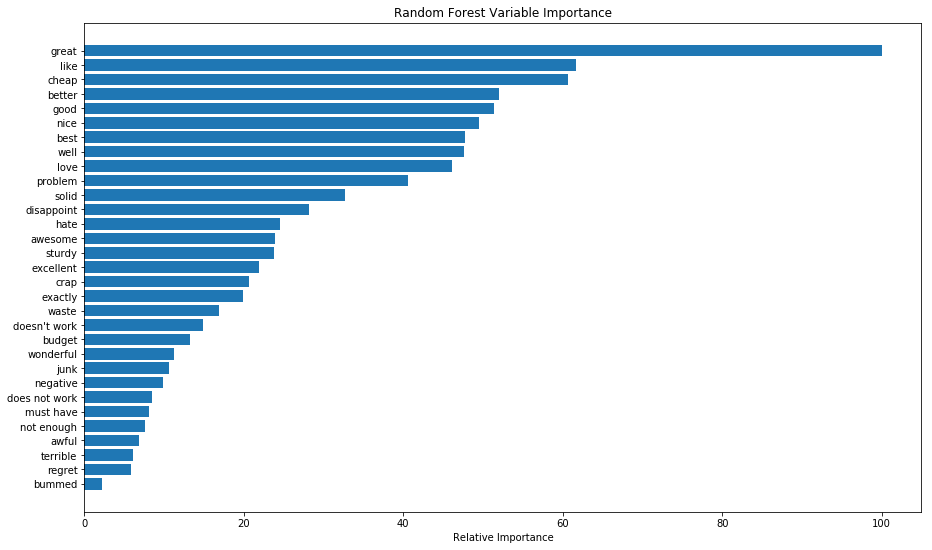

In [14]:
feature_importance = rfc.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(15, 9))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, Xt.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Random Forest Variable Importance')
plt.show()

### Gradient Boosted Decision Tree

In [15]:
gbc = ensemble.GradientBoostingClassifier()

gbc.fit(Xs,Ys)

Y_pred = gbc.predict(Xt)

In [16]:
print('Gradient Boosted Decision Tree')
print('\nTraining Accuracy Score:')
print(gbc.score(Xs,Ys))
cvscores = cross_val_score(gbc, Xs, Ys)
print('\nCross Validation Score:')
print('{}% +/- {}%'.format(round(cvscores.mean(),2),round(cvscores.std()*2,2)))
print('\nTest Accuracy Score')
print(gbc.score(Xt,Yt))
cvscoret = cross_val_score(gbc, Xt, Yt)
print('\nCross Validation Score:')
print('{}% +/- {}%'.format(round(cvscoret.mean(),2),round(cvscoret.std()*2,2)))
print('\nConfusion Matrix:')
print(confusion_matrix(Yt, Y_pred))

Gradient Boosted Decision Tree

Training Accuracy Score:
0.6745

Cross Validation Score:
0.63% +/- 0.01%

Test Accuracy Score
0.6264496637754605

Cross Validation Score:
0.88% +/- 0.0%

Confusion Matrix:
[[ 875  364]
 [3469 5553]]


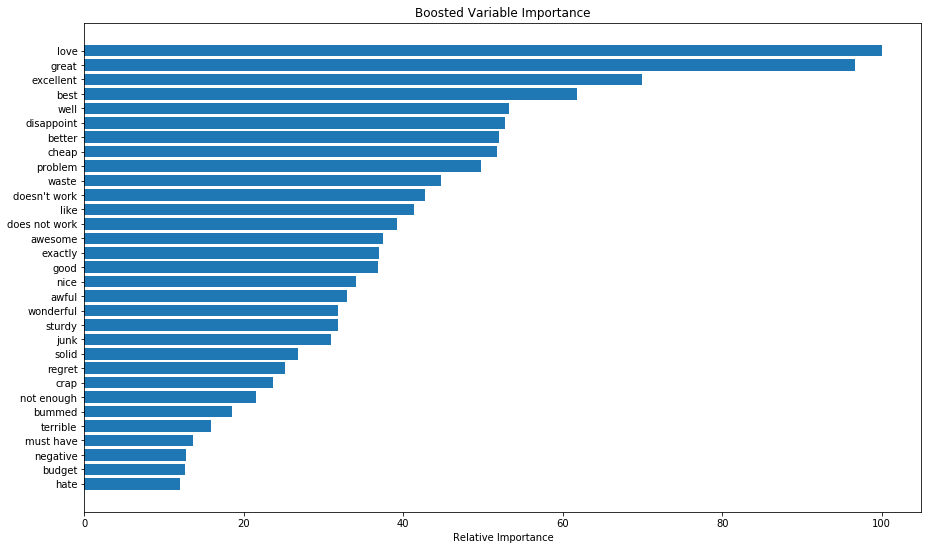

In [17]:
feature_importance = gbc.feature_importances_

# Make importances relative to max importance.
feature_importance = 100.0 * (feature_importance / feature_importance.max())
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(15, 9))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, Xt.columns[sorted_idx])
plt.xlabel('Relative Importance')
plt.title('Boosted Variable Importance')
plt.show()

### Support Vector Classification

In [18]:
svm = SVC()

svm.fit(Xs,Ys)

Y_pred = svm.predict(Xt)

In [19]:
print('Support Vector Machine')
print('\nTraining Accuracy Score:')
print(svm.score(Xs,Ys))
cvscores = cross_val_score(svm, Xs, Ys)
print('\nCross Validation Score:')
print('{}% +/- {}%'.format(round(cvscores.mean(),2),round(cvscores.std()*2,2)))
print('\nTest Accuracy Score')
print(svm.score(Xt,Yt))
cvscoret = cross_val_score(svm, Xt, Yt)
print('\nCross Validation Score:')
print('{}% +/- {}%'.format(round(cvscoret.mean(),2),round(cvscoret.std()*2,2)))
print('\nConfusion Matrix:')
print(confusion_matrix(Yt, Y_pred))

Support Vector Machine

Training Accuracy Score:
0.604

Cross Validation Score:
0.6% +/- 0.01%

Test Accuracy Score
0.4179904492739499

Cross Validation Score:
0.88% +/- 0.0%

Confusion Matrix:
[[1016  223]
 [5749 3273]]


### Naive Bayes

In [20]:
bnb = BernoulliNB()

bnb.fit(Xs,Ys)

Y_pred = bnb.predict(Xt)

In [21]:
print('Naive Bayes')
print('\nTraining Accuracy Score:')
print(bnb.score(Xs,Ys))
cvscores = cross_val_score(bnb, Xs, Ys)
print('\nCross Validation Score:')
print('{}% +/- {}%'.format(round(cvscores.mean(),2),round(cvscores.std()*2,2)))
print('\nTest Accuracy Score')
print(bnb.score(Xt,Yt))
cvscoret = cross_val_score(bnb, Xt, Yt)
print('\nCross Validation Score:')
print('{}% +/- {}%'.format(round(cvscoret.mean(),2),round(cvscoret.std()*2,2)))
print('\nConfusion Matrix:')
print(confusion_matrix(Yt, Y_pred))

Naive Bayes

Training Accuracy Score:
0.6475

Cross Validation Score:
0.63% +/- 0.01%

Test Accuracy Score
0.6164116557840367

Cross Validation Score:
0.88% +/- 0.0%

Confusion Matrix:
[[ 859  380]
 [3556 5466]]


In [22]:
# add all scores into the scores data frame
scores['Music'] = [rfc.score(Xt,Yt),gbc.score(Xt,Yt),svm.score(Xt,Yt),bnb.score(Xt,Yt)]

# Different Categories?

In [23]:
with open('C:\\Code\\Data\\car.json') as f: 
    car = pd.DataFrame(json.loads(line) for line in f)

In [24]:
display(car.head())

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,B00002243X,"[4, 4]",5.0,I needed a set of jumper cables for my new car...,"08 17, 2011",A3F73SC1LY51OO,Alan Montgomery,Work Well - Should Have Bought Longer Ones,1313539200
1,B00002243X,"[1, 1]",4.0,"These long cables work fine for my truck, but ...","09 4, 2011",A20S66SKYXULG2,alphonse,Okay long cables,1315094400
2,B00002243X,"[0, 0]",5.0,Can't comment much on these since they have no...,"07 25, 2013",A2I8LFSN2IS5EO,Chris,Looks and feels heavy Duty,1374710400
3,B00002243X,"[19, 19]",5.0,I absolutley love Amazon!!! For the price of ...,"12 21, 2010",A3GT2EWQSO45ZG,DeusEx,Excellent choice for Jumper Cables!!!,1292889600
4,B00002243X,"[0, 0]",5.0,I purchased the 12' feet long cable set and th...,"07 4, 2012",A3ESWJPAVRPWB4,E. Hernandez,"Excellent, High Quality Starter Cables",1341360000


In [25]:
with open('C:\\Code\\Data\\lawn.json') as f: 
    lawn = pd.DataFrame(json.loads(line) for line in f)

In [26]:
display(lawn.head())

,asin,helpful,overall,reviewText,reviewTime,reviewerID,reviewerName,summary,unixReviewTime
0,B00002N674,"[4, 4]",4.0,Good USA company that stands behind their prod...,"06 21, 2011",A1JZFGZEZVWQPY,"Carter H ""1amazonreviewer@gmail . com""",Great Hoses,1308614400
1,B00002N674,"[0, 0]",5.0,This is a high quality 8 ply hose. I have had ...,"06 9, 2014",A32JCI4AK2JTTG,"Darryl Bennett ""Fuzzy342""",Gilmour 10-58050 8-ply Flexogen Hose 5/8-Inch ...,1402272000
2,B00002N674,"[2, 3]",4.0,It's probably one of the best hoses I've ever ...,"05 5, 2012",A3N0P5AAMP6XD2,H B,Very satisfied!,1336176000
3,B00002N674,"[0, 0]",5.0,I probably should have bought something a bit ...,"07 15, 2013",A2QK7UNJ857YG,Jason,Very high quality,1373846400
4,B00002N674,"[1, 1]",5.0,I bought three of these 5/8-inch Flexogen hose...,"08 5, 2013",AS0CYBAN6EM06,jimmy,Good Hoses,1375660800


# Testing Car Dataset

In [27]:
car_features = pd.DataFrame()

#Words that identify a positive
keywords_pos = ['good','great','awesome','like','love','well','best','better','sturdy','solid',
                'excellent','must have','exactly','wonderful','nice','budget']

for key in keywords_pos:
    car_features[str(key)] = car.reviewText.str.contains(str(key),case=False)
    
#Words that identify or negative, or rule out a positive
keywords_neg = ["disappoint","hate","awful",'does not work', "doesn't work","negative",'bummed',
                'problem','junk','not enough','waste','regret','terrible','crap','cheap']

for key in keywords_neg:
    car_features[str(key)] = car.reviewText.str.contains(str(key),case=False)
    
#Create a feature for whether or not the review was overall positive
car_features['Positive'] = np.where(car['overall']>=4, 1, 0)

In [28]:
Xcar = car_features.drop(['Positive'], axis=1)
Ycar = car_features.Positive

### Random Forest

In [29]:
Y_predcar = rfc.predict(Xcar)

print('Random Forest Test Error Score:')
print(rfc.score(Xcar,Ycar))
cvscore = cross_val_score(rfc, Xcar, Ycar)
print('\nCross Validation Score:')
print('{}% +/- {}%'.format(round(cvscore.mean(),2),round(cvscore.std()*2,2)))
print('\nConfusion Matrix:')
print(confusion_matrix(Ycar, Y_predcar))

Random Forest Test Error Score:
0.5146778684120549

Cross Validation Score:
0.87% +/- 0.0%

Confusion Matrix:
[[1853  725]
 [9211 8684]]


### Gradient Boosted Decision Tree

In [30]:
Y_predcar = gbc.predict(Xcar)

print('Gradient Boosted Test Error Score:')
print(rfc.score(Xcar,Ycar))
cvscore = cross_val_score(gbc, Xcar, Ycar)
print('\nCross Validation Score:')
print('{}% +/- {}%'.format(round(cvscore.mean(),2),round(cvscore.std()*2,2)))
print('\nConfusion Matrix:')
print(confusion_matrix(Ycar, Y_predcar))

Gradient Boosted Test Error Score:
0.5146778684120549

Cross Validation Score:
0.87% +/- 0.0%

Confusion Matrix:
[[1836  742]
 [8410 9485]]


### Support Vector Machines

In [31]:
Y_predcar = svm.predict(Xcar)

print('Support Vector Machine Test Error Score:')
print(rfc.score(Xcar,Ycar))
cvscore = cross_val_score(svm, Xcar, Ycar)
print('\nCross Validation Score:')
print('{}% +/- {}%'.format(round(cvscore.mean(),2),round(cvscore.std()*2,2)))
print('\nConfusion Matrix:')
print(confusion_matrix(Ycar, Y_predcar))

Support Vector Machine Test Error Score:
0.5146778684120549

Cross Validation Score:
0.87% +/- 0.0%

Confusion Matrix:
[[ 2220   358]
 [12853  5042]]


### Naive Bayes

In [32]:
Y_predcar = bnb.predict(Xcar)

print('Naive Bayes Test Error Score:')
print(rfc.score(Xcar,Ycar))
cvscore = cross_val_score(bnb, Xcar, Ycar)
print('\nCross Validation Score:')
print('{}% +/- {}%'.format(round(cvscore.mean(),2),round(cvscore.std()*2,2)))
print('\nConfusion Matrix:')
print(confusion_matrix(Ycar, Y_predcar))

Naive Bayes Test Error Score:
0.5146778684120549

Cross Validation Score:
0.87% +/- 0.0%

Confusion Matrix:
[[1873  705]
 [8554 9341]]


In [33]:
# add all scores into the scores data frame
scores['Car'] = [rfc.score(Xcar,Ycar),gbc.score(Xcar,Ycar),svm.score(Xcar,Ycar),bnb.score(Xcar,Ycar)]

# Testing Lawn Dataset

In [34]:
lawn_features = pd.DataFrame()

#Words that identify a positive
keywords_pos = ['good','great','awesome','like','love','well','best','better','sturdy','solid',
                'excellent','must have','exactly','wonderful','nice','budget']

for key in keywords_pos:
    lawn_features[str(key)] = lawn.reviewText.str.contains(str(key),case=False)
    
#Words that identify or negative, or rule out a positive
keywords_neg = ["disappoint","hate","awful",'does not work', "doesn't work","negative",'bummed',
                'problem','junk','not enough','waste','regret','terrible','crap','cheap']

for key in keywords_neg:
    lawn_features[str(key)] = lawn.reviewText.str.contains(str(key),case=False)
    
#Create a feature for whether or not the review was overall positive
lawn_features['Positive'] = np.where(lawn['overall']>=4, 1, 0)

In [35]:
Xlawn = lawn_features.drop(['Positive'], axis=1)
Ylawn = lawn_features.Positive

### Random Forest

In [36]:
Y_predlawn = rfc.predict(Xlawn)

print('Random Forest Test Error Score:')
print(rfc.score(Xlawn,Ylawn))
cvscore = cross_val_score(rfc, Xlawn, Ylawn)
print('\nCross Validation Score:')
print('{}% +/- {}%'.format(round(cvscore.mean(),2),round(cvscore.std()*2,2)))
print('\nConfusion Matrix:')
print(confusion_matrix(Ylawn, Y_predlawn))

Random Forest Test Error Score:
0.5485232067510548

Cross Validation Score:
0.77% +/- 0.0%

Confusion Matrix:
[[1879  972]
 [5020 5401]]


### Gradient Boosted Decision Tree

In [37]:
Y_predlawn = gbc.predict(Xlawn)

print('Gradient Boosted Test Error Score:')
print(gbc.score(Xlawn,Ylawn))
cvscore = cross_val_score(gbc, Xlawn, Ylawn)
print('\nCross Validation Score:')
print('{}% +/- {}%'.format(round(cvscore.mean(),2),round(cvscore.std()*2,2)))
print('\nConfusion Matrix:')
print(confusion_matrix(Ylawn, Y_predlawn))

Gradient Boosted Test Error Score:
0.5921488848704038

Cross Validation Score:
0.79% +/- 0.0%

Confusion Matrix:
[[1848 1003]
 [4410 6011]]


### Support Vector Machines

In [38]:
Y_predlawn = svm.predict(Xlawn)

print('Gradient Boosted Test Error Score:')
print(svm.score(Xlawn,Ylawn))
cvscore = cross_val_score(svm, Xlawn, Ylawn)
print('\nCross Validation Score:')
print('{}% +/- {}%'.format(round(cvscore.mean(),2),round(cvscore.std()*2,2)))
print('\nConfusion Matrix:')
print(confusion_matrix(Ylawn, Y_predlawn))

Gradient Boosted Test Error Score:
0.42239300783604583

Cross Validation Score:
0.79% +/- 0.0%

Confusion Matrix:
[[2343  508]
 [7158 3263]]


### Naive Bayes

In [39]:
Y_predlawn = bnb.predict(Xlawn)

print('Gradient Boosted Test Error Score:')
print(gbc.score(Xlawn,Ylawn))
cvscore = cross_val_score(bnb, Xlawn, Ylawn)
print('\nCross Validation Score:')
print('{}% +/- {}%'.format(round(cvscore.mean(),2),round(cvscore.std()*2,2)))
print('\nConfusion Matrix:')
print(confusion_matrix(Ylawn, Y_predlawn))

Gradient Boosted Test Error Score:
0.5921488848704038

Cross Validation Score:
0.79% +/- 0.0%

Confusion Matrix:
[[1874  977]
 [4442 5979]]


In [40]:
# add all scores into the scores data frame
scores['Lawn'] = [rfc.score(Xlawn,Ylawn),gbc.score(Xlawn,Ylawn),svm.score(Xlawn,Ylawn),bnb.score(Xlawn,Ylawn)]

# Conclusion

In [41]:
scores.index = ['RandomForest','Boosted','SVM','NaiveBayes']
display(scores)

,Music,Car,Lawn
RandomForest,0.590001,0.514678,0.548523
Boosted,0.626450,0.552972,0.592149
SVM,0.417990,0.354711,0.422393
NaiveBayes,0.616412,0.547746,0.591697


Its seems my classifier does not work nearly as well on other review types as it does on music reviews.  This makes sense, as music is can be a very niche hobby with unique lingo and perspectives on what is positive and negative.  Come to think of it, the car and lawn product review dataset probably fall into the same category. The products being reviewed and language of the reviewers for thses particular categories being to obtuse probably leads to lower cross performance than other sentiment classifier situations might have.

http://jmcauley.ucsd.edu/data/amazon/